# Carga del DS y funciones

In [ ]:
#ejecutar desde colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importar librerias y funciones necesarias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import ast
#Libreria Imblearan para manejo de datos desbalanceados
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,EditedNearestNeighbours
from imblearn.combine import SMOTEENN,SMOTETomek

#Modelos a usar
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, make_scorer,confusion_matrix, f1_score, balanced_accuracy_score, precision_score,recall_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV,train_test_split,ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
def model_comparison_test(x_train, x_test, y_train, y_test,clasificador,scaler,parameters,random_state=12):
  '''
  Función para probar los modelos con el mismo conjunto de entrenamiento 
  '''
  parameters = ParameterGrid(parameters)
  columns=['balanced_acc_test','f1_test','recall_test','specificity_test']
  test_score = np.zeros((len(parameters),len(columns)))
  for c,params in enumerate(parameters):

    clasificador.set_params(**params)
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    clasificador.fit(x_train, y_train)

    y_pred=clasificador.predict(x_test)
    test_score[c,0] = balanced_accuracy_score(y_test,y_pred)
    test_score[c,1] = f1_score(y_test,y_pred,average='weighted')
    test_score[c,2] = recall_score(y_test,y_pred)
    #specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_score[c,3] = tn / (tn+fp)
    print('kfold terminado: ',params)
     
  return pd.DataFrame(data=test_score,index=list(parameters),columns=columns)
  
def signal_labels_from_df(df):
  y=[]
  for i,val in df[['AV', 'MV', 'PV', 'TV', 'Phc','#Murmur locations']].iterrows():
      if pd.isna(val['#Murmur locations']):
          y.append(0)
      else:
          locs = val['#Murmur locations'].split('+')
          #print(locs)
          if val[val==1].index.values[0] in locs:
              y.append(1)
          else:
              y.append(0)
  return np.array(y)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/scripts/patient_info.csv', index_col=0) #infortmacion del paciente
labels_dic = {'Absent':0,'Present':1,'Unknown':0} #Los unknown se asignan como si fueran ausentes porque no tienen anotado presencia de murmur y confunde al modelo de señales
df['label_v']=df['label'].apply(lambda x: labels_dic[x])

In [ ]:
#cargar carecteristicas de las señales
w=0.2
resamp=1000
signal_features=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/scripts/extracted_features/'+'features'+str(w)+str(resamp)+'.csv', index_col=0)
signal_features['id']=signal_features['id'].apply(lambda x: int(x))

In [ ]:
df_demo_x_full = df[['id','#Age', '#Sex', '#Height', '#Weight', '#Pregnancy status','#Murmur locations','label','label_v']]
df_demo_x_full = pd.get_dummies(df_demo_x_full,columns=['#Age', '#Sex','#Pregnancy status'],drop_first=True)
df_demo_y_full= df[['label_v']] #Solo se usa para la estratificacion

In [ ]:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_demo_x_full, df_demo_y_full, test_size=0.20, random_state=12, stratify=df_demo_y_full)

In [ ]:
df_y_test.value_counts(),df_y_train.value_counts()

(label_v
 0          153
 1           36
 dtype: int64, label_v
 0          610
 1          143
 dtype: int64)

In [ ]:
df_signal_train = signal_features.merge(df_x_train,on='id')
df_signal_test = signal_features.merge(df_x_test,on='id')

In [ ]:
df_signal_train.shape,df_signal_test.shape

((2513, 107), (650, 107))

In [ ]:
cols_x = [' mfcc1 min', ' mfcc2 min', ' mfcc3 min', ' mfcc5 min', ' mfcc11 min', ' mfcc13 min', ' zcr min', ' sr90 min', ' sr10 min', ' sc min', ' mfcc5 max', ' mfcc6 max', ' mfcc9 max', ' mfcc13 max', ' zcr max', ' sr10 max', ' sc max', ' mfcc1 med', ' mfcc3 med', ' mfcc4 med', ' mfcc5 med', ' mfcc6 med', ' mfcc7 med', ' mfcc8 med', ' mfcc9 med', ' mfcc11 med', ' mfcc13 med', ' zcr med', ' sr10 med', ' sc med', ' mfcc1 mean', ' mfcc3 mean', ' mfcc4 mean', ' mfcc5 mean', ' mfcc6 mean', ' mfcc7 mean', ' mfcc11 mean', ' mfcc12 mean', ' mfcc13 mean', ' zcr mean', ' sc mean', ' mfcc2 std', ' mfcc7 std', ' mfcc11 std', ' mfcc12 std', ' zcr std', ' rms std', ' sr90 std', ' sc std']

x_signal_train = df_signal_train[cols_x].values
x_signal_test = df_signal_test[cols_x].values

y_signal_train=signal_labels_from_df(df_signal_train)
y_signal_test=signal_labels_from_df(df_signal_test)

In [ ]:
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_signal_train),'Present: ',sum(y_signal_train), 'Porcentaje: ',sum(y_signal_train)/len(y_signal_train))
print('Datos Prueba:\n', 'Cantidad: ', len(y_signal_test),'Present: ',sum(y_signal_test), 'Porcentaje: ',sum(y_signal_test)/len(y_signal_test))

Datos Entrenamiento:
 Cantidad:  2513 Present:  397 Porcentaje:  0.1579785117389574
Datos Prueba:
 Cantidad:  650 Present:  102 Porcentaje:  0.15692307692307692


# Modelo de la señales

### MLP

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_signal_train, y_signal_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4232 Present:  2116 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]#toco <0.65
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
df_model=model_comparison_test(x_resamp, x_signal_test, y_resamp, y_signal_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 6

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.757371,0.822933,0.686275,0.828467
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.749016,0.744003,0.813725,0.684307
"{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}",0.773204,0.798574,0.774510,0.771898
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.769554,0.793615,0.774510,0.764599
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.769554,0.793615,0.774510,0.764599
"{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.770234,0.784099,0.794118,0.746350
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.773544,0.793846,0.784314,0.762774
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.773544,0.793846,0.784314,0.762774
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}",0.767533,0.861756,0.637255,0.897810
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}",0.767962,0.801776,0.754902,0.781022


              precision    recall  f1-score   support

      Absent       0.95      0.77      0.85       548
     Present       0.39      0.77      0.52       102

    accuracy                           0.77       650
   macro avg       0.67      0.77      0.68       650
weighted avg       0.86      0.77      0.80       650



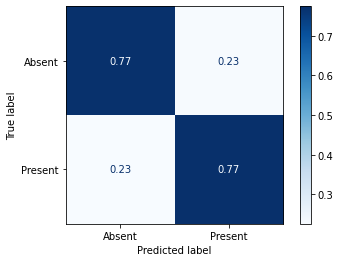

In [ ]:
clf_mlp = make_pipeline(scaler, 
                    clf.set_params(**{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}))
clf_mlp.fit(x_resamp, y_resamp)
y_pred=clf_mlp.predict(x_signal_test)
print(classification_report(y_signal_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_signal_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### LR

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_signal_train, y_signal_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4232 Present:  2116 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
df_model=model_comparison_test(x_resamp, x_signal_test, y_resamp, y_signal_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 200, 'solver': 'lbfgs'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 120, 'solver': 'newton-cg'}",0.768874,0.803011,0.754902,0.782847
"{'C': 150, 'solver': 'newton-cg'}",0.768874,0.803011,0.754902,0.782847
"{'C': 150, 'solver': 'lbfgs'}",0.768874,0.803011,0.754902,0.782847
"{'C': 100, 'solver': 'newton-cg'}",0.768874,0.803011,0.754902,0.782847
"{'C': 100, 'solver': 'lbfgs'}",0.767962,0.801776,0.754902,0.781022
"{'C': 120, 'solver': 'lbfgs'}",0.768874,0.803011,0.754902,0.782847
"{'C': 250, 'solver': 'lbfgs'}",0.767050,0.800542,0.754902,0.779197
"{'C': 250, 'solver': 'newton-cg'}",0.767050,0.800542,0.754902,0.779197
"{'C': 300, 'solver': 'newton-cg'}",0.767050,0.800542,0.754902,0.779197
"{'C': 200, 'solver': 'lbfgs'}",0.767962,0.801776,0.754902,0.781022


              precision    recall  f1-score   support

      Absent       0.94      0.78      0.86       548
     Present       0.39      0.75      0.52       102

    accuracy                           0.78       650
   macro avg       0.67      0.77      0.69       650
weighted avg       0.86      0.78      0.80       650



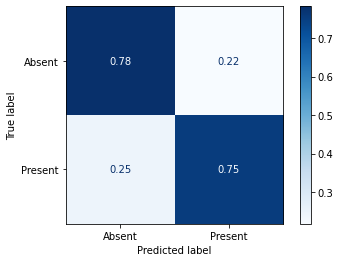

In [ ]:
clf_lr = make_pipeline(scaler, 
                    clf.set_params(**{'C': 120, 'solver': 'newton-cg'}))
clf_lr.fit(x_resamp, y_resamp)
y_pred=clf_lr.predict(x_signal_test)
print(classification_report(y_signal_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_signal_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

# Modelo Paciente

In [ ]:
df_x_train.shape,df_x_test.shape, signal_features.shape

((753, 12), (189, 12), (3163, 96))

In [ ]:
from sklearn.impute import KNNImputer
# Imputacion a partir de KNN
imputer = KNNImputer(n_neighbors=3, weights="uniform")
df_x_train[['#Height','#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult', '#Sex_Male', '#Pregnancy status_True']]=imputer.fit_transform(df_x_train[['#Height','#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True']])
df_x_test[['#Height','#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult', '#Sex_Male', '#Pregnancy status_True']]=imputer.transform(df_x_test[['#Height','#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True']])

In [ ]:
df_x_train

,id,#Height,#Weight,#Murmur locations,label,label_v,#Age_Child,#Age_Infant,#Age_Neonate,#Age_Young Adult,#Sex_Male,#Pregnancy status_True
902,85282,117.0,22.7,NaN,Absent,0,1,0,0,0,1,0
927,85328,114.0,19.6,NaN,Absent,0,1,0,0,0,1,0
623,84778,106.0,16.7,NaN,Absent,0,1,0,0,0,1,0
369,50747,115.0,24.2,NaN,Absent,0,1,0,0,0,0,0
203,50209,126.0,30.7,AV+MV+PV+TV,Present,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19,40840,147.0,36.1,AV+MV+PV+TV,Present,1,0,0,0,0,0,0
152,50089,115.0,20.5,NaN,Absent,0,1,0,0,0,1,0
408,50818,103.0,18.8,NaN,Absent,0,1,0,0,0,1,0
535,69125,101.0,16.8,NaN,Absent,0,1,0,0,0,1,0


In [ ]:
def signal_model_output(df_signal,clf):
  '''
  Funcion para obtener las salidas de modelo de senales y convertirlas en entradas para el siguiente modelo,
  para un mismo paciente
  '''
  prob = clf.predict_proba(df_signal.values)
  pred = clf.predict(df_signal.values)
  out_pos = list()
  out_neg = list()
  for i,prediction in enumerate(pred):
    if prediction==0:
      out_neg.append(prob[i,0])
    if prediction==1:
      out_pos.append(prob[i,1])
  
  if len(out_pos)==0:
    out_p = 0
  else:
    out_p = np.mean(out_pos)
  if len(out_neg)==0:
    out_n = 0
  else:
    out_n = np.mean(out_neg)
  return out_p,out_n

def makeset_final_model(df_demo,df_signal,cols_x,clf_signal):
  '''
  Genera un conjunto de datos para todos los pacientes que se le ingresen
  '''
  df = df_demo.copy()
  out_pos = list()
  out_neg = list()
  for id in df_demo['id']:
    out_p,out_n = signal_model_output(df_signal[df_signal['id']==id][cols_x],clf_signal)
    out_pos.append(out_p)
    out_neg.append(out_n)
  df['out_pos']=np.array(out_pos)
  df['out_neg']=np.array(out_neg)
  return df

## Signal MLP

In [ ]:
df_patient_train=makeset_final_model(df_x_train,df_signal_train,cols_x,clf_mlp)
df_patient_test=makeset_final_model(df_x_test,df_signal_test,cols_x,clf_mlp)

In [ ]:
x_patient_train = df_patient_train[['#Height', '#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True', 'out_pos', 'out_neg']].values
x_patient_test = df_patient_test[['#Height', '#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True', 'out_pos', 'out_neg']].values
y_patient_train = df_patient_train['label_v'].values
y_patient_test = df_patient_test['label_v'].values

### SVM

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
parameters={'C':[0.01,0.1,0.3,0.5,0.8,1],
            'kernel':['poly','rbf'],
            'gamma':['scale','auto']}
df_model=model_comparison_test(x_patient_train, x_patient_test, y_patient_train, y_patient_test,clf,scaler,parameters,random_state=12)

kfold terminado:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.5, 'gamma

In [ ]:
df_model

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}",0.738562,0.797407,0.666667,0.810458
"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}",0.648693,0.494960,0.944444,0.352941
"{'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}",0.500000,0.060952,1.000000,0.000000
"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.500000,0.060952,1.000000,0.000000
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.762255,0.816064,0.694444,0.830065
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.774510,0.792503,0.777778,0.771242
"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",0.500000,0.060952,1.000000,0.000000
"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.741013,0.813555,0.638889,0.843137
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.753268,0.790783,0.722222,0.784314
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.754085,0.778431,0.750000,0.758170


### LR

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
parameters={'C':[0.01,0.1,0.3,5,10,50,80,100],
            'solver':['newton-cg','lbfgs']}
df_model=model_comparison_test(x_patient_train, x_patient_test, y_patient_train, y_patient_test,clf,scaler,parameters,random_state=12)

kfold terminado:  {'C': 0.01, 'solver': 'newton-cg'}
kfold terminado:  {'C': 0.01, 'solver': 'lbfgs'}
kfold terminado:  {'C': 0.1, 'solver': 'newton-cg'}
kfold terminado:  {'C': 0.1, 'solver': 'lbfgs'}
kfold terminado:  {'C': 0.3, 'solver': 'newton-cg'}
kfold terminado:  {'C': 0.3, 'solver': 'lbfgs'}
kfold terminado:  {'C': 5, 'solver': 'newton-cg'}
kfold terminado:  {'C': 5, 'solver': 'lbfgs'}
kfold terminado:  {'C': 10, 'solver': 'newton-cg'}
kfold terminado:  {'C': 10, 'solver': 'lbfgs'}
kfold terminado:  {'C': 50, 'solver': 'newton-cg'}
kfold terminado:  {'C': 50, 'solver': 'lbfgs'}
kfold terminado:  {'C': 80, 'solver': 'newton-cg'}
kfold terminado:  {'C': 80, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}


In [ ]:
df_model

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 0.01, 'solver': 'newton-cg'}",0.705065,0.765915,0.638889,0.771242
"{'C': 0.01, 'solver': 'lbfgs'}",0.705065,0.765915,0.638889,0.771242
"{'C': 0.1, 'solver': 'newton-cg'}",0.729575,0.772307,0.694444,0.764706
"{'C': 0.1, 'solver': 'lbfgs'}",0.729575,0.772307,0.694444,0.764706
"{'C': 0.3, 'solver': 'newton-cg'}",0.736111,0.781052,0.694444,0.777778
"{'C': 0.3, 'solver': 'lbfgs'}",0.736111,0.781052,0.694444,0.777778
"{'C': 5, 'solver': 'newton-cg'}",0.725490,0.780015,0.666667,0.784314
"{'C': 5, 'solver': 'lbfgs'}",0.725490,0.780015,0.666667,0.784314
"{'C': 10, 'solver': 'newton-cg'}",0.722222,0.775668,0.666667,0.777778
"{'C': 10, 'solver': 'lbfgs'}",0.722222,0.775668,0.666667,0.777778


## Signal LR

In [ ]:
df_patient_train=makeset_final_model(df_x_train,df_signal_train,cols_x,clf_lr)
df_patient_test=makeset_final_model(df_x_test,df_signal_test,cols_x,clf_lr)

In [ ]:
x_patient_train = df_patient_train[['#Height', '#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True', 'out_pos', 'out_neg']].values
x_patient_test = df_patient_test[['#Height', '#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True', 'out_pos', 'out_neg']].values
y_patient_train = df_patient_train['label_v'].values
y_patient_test = df_patient_test['label_v'].values

### SVM

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
parameters={'C':[0.01,0.1,0.3,0.5,0.8,1],
            'kernel':['poly','rbf'],
            'gamma':['scale','auto']}
df_model=model_comparison_test(x_patient_train, x_patient_test, y_patient_train, y_patient_test,clf,scaler,parameters,random_state=12)

kfold terminado:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.5, 'gamma

In [ ]:
df_model

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}",0.772059,0.775371,0.805556,0.738562
"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}",0.584150,0.332704,0.972222,0.196078
"{'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}",0.500000,0.060952,1.000000,0.000000
"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.500000,0.060952,1.000000,0.000000
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.778595,0.784315,0.805556,0.751634
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.732843,0.720952,0.805556,0.660131
"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",0.500000,0.060952,1.000000,0.000000
"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.784314,0.805809,0.777778,0.790850
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.773693,0.804929,0.750000,0.797386
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.762255,0.761905,0.805556,0.718954


              precision    recall  f1-score   support

      Absent       0.94      0.78      0.85       153
     Present       0.45      0.78      0.57        36

    accuracy                           0.78       189
   macro avg       0.69      0.78      0.71       189
weighted avg       0.84      0.78      0.80       189



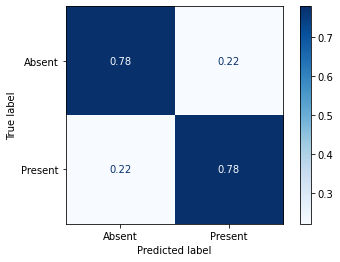

In [ ]:
scaler = MinMaxScaler((0,1))
clf_patient=SVC(class_weight='balanced',random_state=12)
params={'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
clf_patient= make_pipeline(scaler, 
                    clf_patient.set_params(**params))
clf.fit(x_patient_train, y_patient_train)
y_pred=clf.predict(x_patient_test)
print(classification_report(y_patient_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_patient_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### LR

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
parameters={'C':[0.01,0.1,0.3,5,10,50,80,100],
            'solver':['newton-cg','lbfgs']}
df_model=model_comparison_test(x_patient_train, x_patient_test, y_patient_train, y_patient_test,clf,scaler,parameters,random_state=12)

kfold terminado:  {'C': 0.01, 'solver': 'newton-cg'}
kfold terminado:  {'C': 0.01, 'solver': 'lbfgs'}
kfold terminado:  {'C': 0.1, 'solver': 'newton-cg'}
kfold terminado:  {'C': 0.1, 'solver': 'lbfgs'}
kfold terminado:  {'C': 0.3, 'solver': 'newton-cg'}
kfold terminado:  {'C': 0.3, 'solver': 'lbfgs'}
kfold terminado:  {'C': 5, 'solver': 'newton-cg'}
kfold terminado:  {'C': 5, 'solver': 'lbfgs'}
kfold terminado:  {'C': 10, 'solver': 'newton-cg'}
kfold terminado:  {'C': 10, 'solver': 'lbfgs'}
kfold terminado:  {'C': 50, 'solver': 'newton-cg'}
kfold terminado:  {'C': 50, 'solver': 'lbfgs'}
kfold terminado:  {'C': 80, 'solver': 'newton-cg'}
kfold terminado:  {'C': 80, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}


In [ ]:
df_model

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 0.01, 'solver': 'newton-cg'}",0.755719,0.752885,0.805556,0.705882
"{'C': 0.01, 'solver': 'lbfgs'}",0.755719,0.752885,0.805556,0.705882
"{'C': 0.1, 'solver': 'newton-cg'}",0.768791,0.770889,0.805556,0.732026
"{'C': 0.1, 'solver': 'lbfgs'}",0.768791,0.770889,0.805556,0.732026
"{'C': 0.3, 'solver': 'newton-cg'}",0.778595,0.784315,0.805556,0.751634
"{'C': 0.3, 'solver': 'lbfgs'}",0.778595,0.784315,0.805556,0.751634
"{'C': 5, 'solver': 'newton-cg'}",0.777778,0.796939,0.777778,0.777778
"{'C': 5, 'solver': 'lbfgs'}",0.777778,0.796939,0.777778,0.777778
"{'C': 10, 'solver': 'newton-cg'}",0.777778,0.796939,0.777778,0.777778
"{'C': 10, 'solver': 'lbfgs'}",0.777778,0.796939,0.777778,0.777778


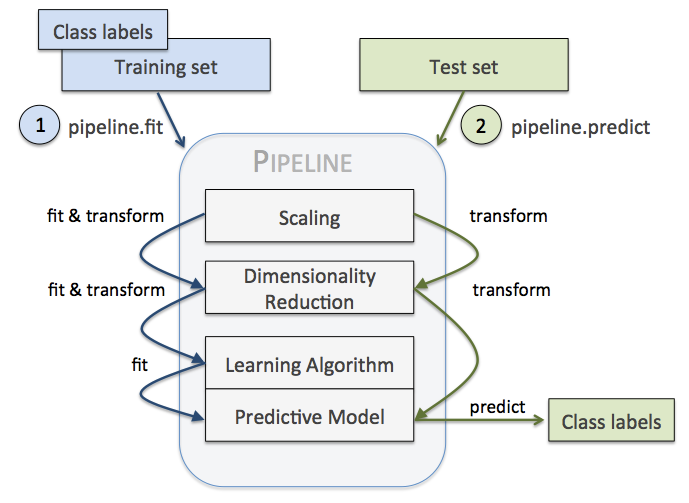

## 3 clases

In [ ]:
x_patient_train = df_patient_train[['#Height', '#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True', 'out_pos', 'out_neg']].values
x_patient_test = df_patient_test[['#Height', '#Weight','#Age_Child', '#Age_Infant', '#Age_Neonate', '#Age_Young Adult',
                                    '#Sex_Male', '#Pregnancy status_True', 'out_pos', 'out_neg']].values
y_patient_train = df_patient_train['label'].values
y_patient_test = df_patient_test['label'].values

In [ ]:
def model_comparison_test(x_train, x_test, y_train, y_test,clasificador,scaler,parameters,random_state=12):
  '''
  Función para probar los modelos con el mismo conjunto de entrenamiento 
  '''
  parameters = ParameterGrid(parameters)
  columns=['balanced_acc_test','f1_test','recall_test','specificity_test']
  test_score = np.zeros((len(parameters),len(columns)))
  for c,params in enumerate(parameters):

    clasificador.set_params(**params)
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    clasificador.fit(x_train, y_train)

    y_pred=clasificador.predict(x_test)
    test_score[c,0] = balanced_accuracy_score(y_test,y_pred)
    test_score[c,1] = f1_score(y_test,y_pred,average='weighted')
    test_score[c,2] = 0#recall_score(y_test,y_pred='weighted')
    #specificity
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_score[c,3] = 0#tn / (tn+fp)
    print('kfold terminado: ',params)
     
  return pd.DataFrame(data=test_score,index=list(parameters),columns=columns)

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
parameters={'C':[0.01,0.1,0.3,0.5,0.8,1],
            'kernel':['poly','rbf'],
            'gamma':['scale','auto']}
df_model=model_comparison_test(x_patient_train, x_patient_test, y_patient_train, y_patient_test,clf,scaler,parameters,random_state=12)

kfold terminado:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'auto', 'kernel': 'poly'}
kfold terminado:  {'C': 0.5, 'gamma

In [ ]:
df_model

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}",0.617809,0.664795,0.0,0.0
"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}",0.333333,0.637518,0.0,0.0
"{'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}",0.333333,0.637518,0.0,0.0
"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.333333,0.637518,0.0,0.0
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.573877,0.663654,0.0,0.0
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.564224,0.629874,0.0,0.0
"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",0.333333,0.637518,0.0,0.0
"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.622931,0.715068,0.0,0.0
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.638692,0.680821,0.0,0.0
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.603625,0.648284,0.0,0.0
